In [1]:
!nvidia-smi

Sat Apr 13 18:12:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce MX150           On  | 00000000:01:00.0 Off |                  N/A |
| N/A   41C    P8              N/A / ERR! |      6MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import torch

torch.cuda.get_device_name(0)

'NVIDIA GeForce MX150'

In [3]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

2.2.2
11.8
True


## Karate

(undirected and unweighted)

In [4]:
def print_dataset_info(dataset):
    print(f"Dataset: {dataset}")
    print(f"Number of samples: {len(dataset)}")
    print(f"Number of features: {dataset.num_features}")
    print(f"Number of classes: {dataset.num_classes}")

In [5]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print_dataset_info(dataset)

Dataset: KarateClub()
Number of samples: 1
Number of features: 34
Number of classes: 4


In [6]:
G = dataset[0]
G

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])

In [7]:
G.x

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [8]:
G.y

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])

In [9]:
G.train_mask

tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])

In [10]:
G.num_nodes

34

In [11]:
G.edge_index

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
         33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
        [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
          3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
          1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  5, 16,  0,  1,
          2,  3,  0,  2, 30, 32, 33,  2, 33,  0,  4

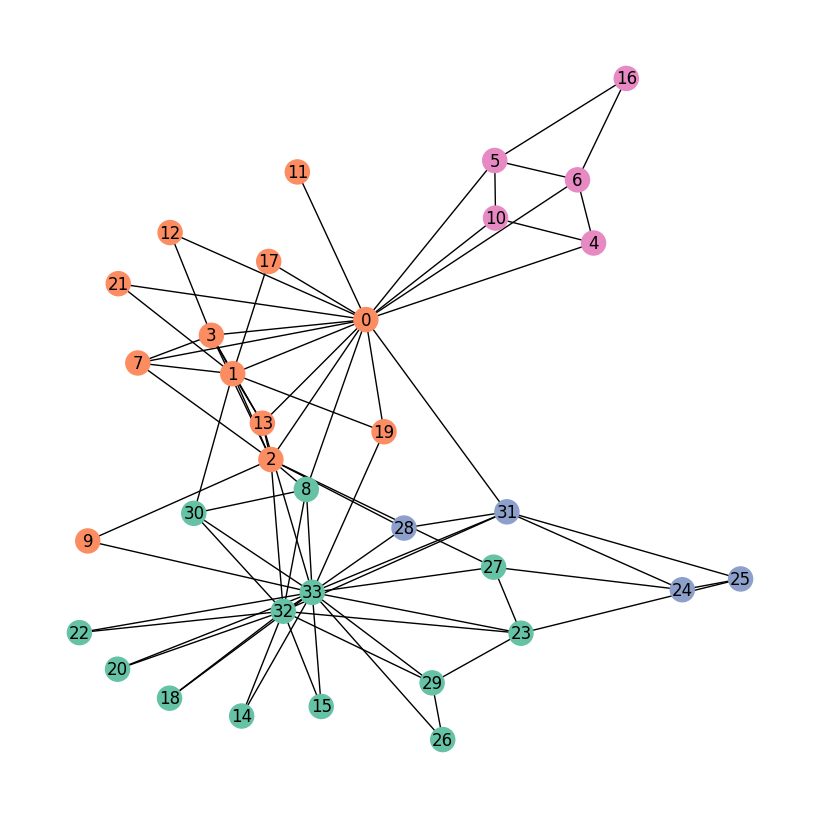

In [12]:
# Visualize the dataset

import networkx as nx
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

# Create an adjacency matrix
adjacency_matrix = torch.zeros(G.num_nodes, G.num_nodes)
adjacency_matrix[G.edge_index[0], G.edge_index[1]] = 1

# Convert the adjacency matrix to numpy
adjacency_matrix_np = adjacency_matrix.numpy()

# Now create the graph
nx_G = nx.Graph(adjacency_matrix_np)
pos = nx.spring_layout(nx_G, seed=42)

color_map = plt.get_cmap("Set2")

colors = [color_map.colors[i] for i in G.y]

nx.draw(nx_G, pos, with_labels=True, node_color=colors, cmap="Set2")
plt.show()

In [13]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [14]:
from torch_geometric.transforms import RandomNodeSplit

data = RandomNodeSplit(num_val=0, num_test=0.2)(G)
data, data.train_mask, data.val_mask, data.test_mask

(Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34], val_mask=[34], test_mask=[34]),
 tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True,
          True,  True,  True, False,  True, False, False,  True,  True,  True,
          True,  True,  True, False,  True, False,  True,  True,  True,  True,
          True,  True, False,  True]),
 tensor([False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False]),
 tensor([False, False, False,  True, False, False, False, False, False, False,
         False, False, False,  True, False,  True,  True, False, False, False,
         False, False, False,  True, False,  True, False, False, False, False,
         False, False,  True, False]))

In [15]:
def generate_adjacency_matrix(num_nodes, edge_index):
    adjacency_matrix = torch.zeros(num_nodes, num_nodes)
    adjacency_matrix[edge_index[0], edge_index[1]] = 1
    return adjacency_matrix.numpy()

/home/ignatella/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1026: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


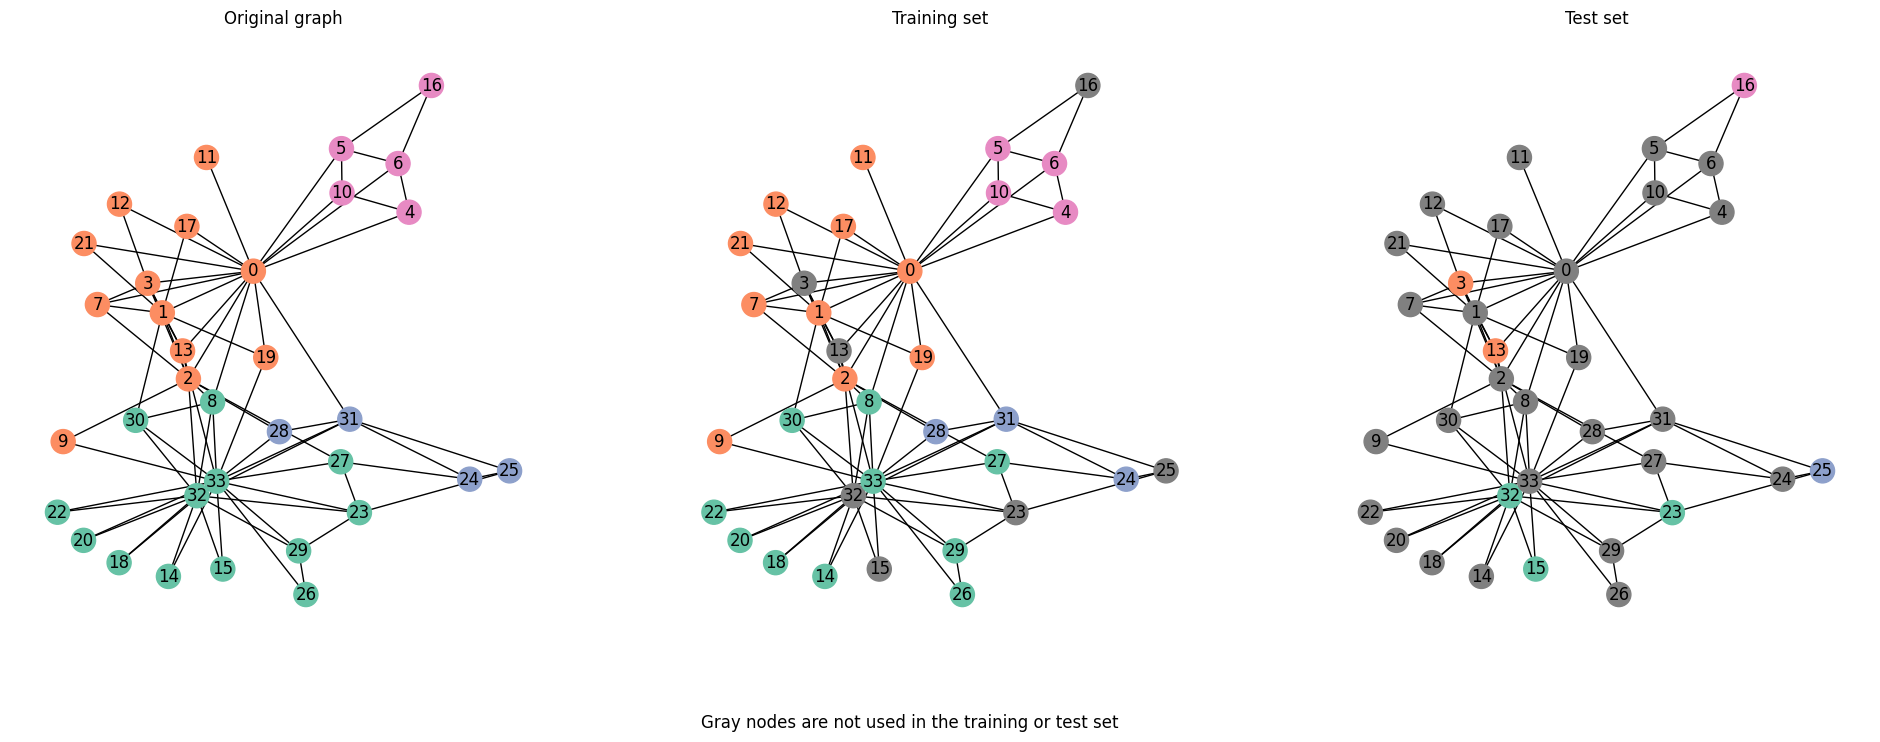

In [16]:
# plot nodes of the training set, unused nodes color is gray
plt.figure(figsize=(24, 8))

# Create an adjacency matrix
adjacency_matrix = generate_adjacency_matrix(data.num_nodes, data.edge_index)
# Now create the graph
nx_G = nx.Graph(adjacency_matrix)
# Create the layout
pos = nx.spring_layout(nx_G, seed=42)

color_map = plt.get_cmap("Set2")

original_colors = [color_map.colors[data.y[i].item()] for i in range(data.num_nodes)]
train_colors = [color_map.colors[data.y[i].item()] if use_node else "gray" for i, use_node in enumerate(data.train_mask)]
test_colors = [color_map.colors[data.y[i].item()] if use_node else "gray" for i, use_node in enumerate(data.test_mask)]

# Plot the original graph

plt.subplot(1, 3, 1)
nx.draw(nx_G, pos, with_labels=True, node_color=original_colors, cmap="Set2")
plt.title("Original graph")

# Plot the training set
plt.subplot(1, 3, 2)
nx.draw(nx_G, pos, with_labels=True, node_color=train_colors, cmap="Set2")
plt.title("Training set")

# Plot the test set
plt.subplot(1, 3, 3)
nx.draw(nx_G, pos, with_labels=True, node_color=test_colors, cmap="Set2")
plt.title("Test set")

# add additional text, that gray nodes are not used in the training or test set

plt.figtext(0.5, 0.01, "Gray nodes are not used in the training or test set", wrap=True, horizontalalignment='center', fontsize=12)

plt.show()

In [17]:
data.x[data.train_mask]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0

In [18]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels,)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.log_softmax(x, dim=1)
        return x

In [19]:
# convert data.y to float
model = GCN(in_channels=-1, hidden_channels=64, out_channels=4)
model(data.x, data.edge_index)

tensor([[-1.4307, -1.3925, -1.4816, -1.2548],
        [-1.4118, -1.4034, -1.4641, -1.2756],
        [-1.4235, -1.3865, -1.4365, -1.3041],
        [-1.3923, -1.3954, -1.4330, -1.3274],
        [-1.3902, -1.3713, -1.4284, -1.3568],
        [-1.3743, -1.3609, -1.4535, -1.3594],
        [-1.3761, -1.3499, -1.4496, -1.3723],
        [-1.3920, -1.3896, -1.4325, -1.3336],
        [-1.4214, -1.3870, -1.4166, -1.3233],
        [-1.4219, -1.3887, -1.3862, -1.3496],
        [-1.3893, -1.3731, -1.4309, -1.3535],
        [-1.4440, -1.3835, -1.4225, -1.3013],
        [-1.3791, -1.4016, -1.4133, -1.3522],
        [-1.4066, -1.3847, -1.4274, -1.3292],
        [-1.4229, -1.3964, -1.4005, -1.3279],
        [-1.4300, -1.3957, -1.4063, -1.3168],
        [-1.3672, -1.3490, -1.4496, -1.3821],
        [-1.4064, -1.3988, -1.4289, -1.3148],
        [-1.4215, -1.3952, -1.3871, -1.3430],
        [-1.4095, -1.3969, -1.4267, -1.3157],
        [-1.4150, -1.4001, -1.3828, -1.3485],
        [-1.3873, -1.3977, -1.4402

In [20]:
# encode the class labels, so currently we have [1, 1, 1, 1, 2, 2, 4, 4, 3, 3, 3]
# it should become [[1., 0., 0., 0.], etc]

from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse_output=False)
data.y_encoded = onehot_encoder.fit_transform(data.y.view(-1, 1))
data.y_encoded = torch.tensor(data.y_encoded, dtype=torch.float32)

data.y_encoded

tensor([[0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]])

In [21]:
model = GCN(in_channels=-1, hidden_channels=64, out_channels=dataset.num_classes)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
model.train()
for epoch in range(20):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)

    loss = criterion(out[data.train_mask], data.y_encoded[data.train_mask])
    loss.backward()
    optimizer.step()

    acc = (out[data.train_mask].argmax(dim=1) == data.y[data.train_mask]).sum().item() / data.train_mask.sum().item()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss {loss.item()} | Train Accuracy {acc}")

Epoch 0 | Loss 1.3869296312332153 | Train Accuracy 0.2222222222222222
Epoch 10 | Loss 0.904022753238678 | Train Accuracy 0.7037037037037037


In [22]:
# Test the model

model.eval()
out = model(data.x, data.edge_index)

acc = (out[data.test_mask].argmax(dim=1) == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
print(f"Test Accuracy {acc}")

Test Accuracy 0.8571428571428571


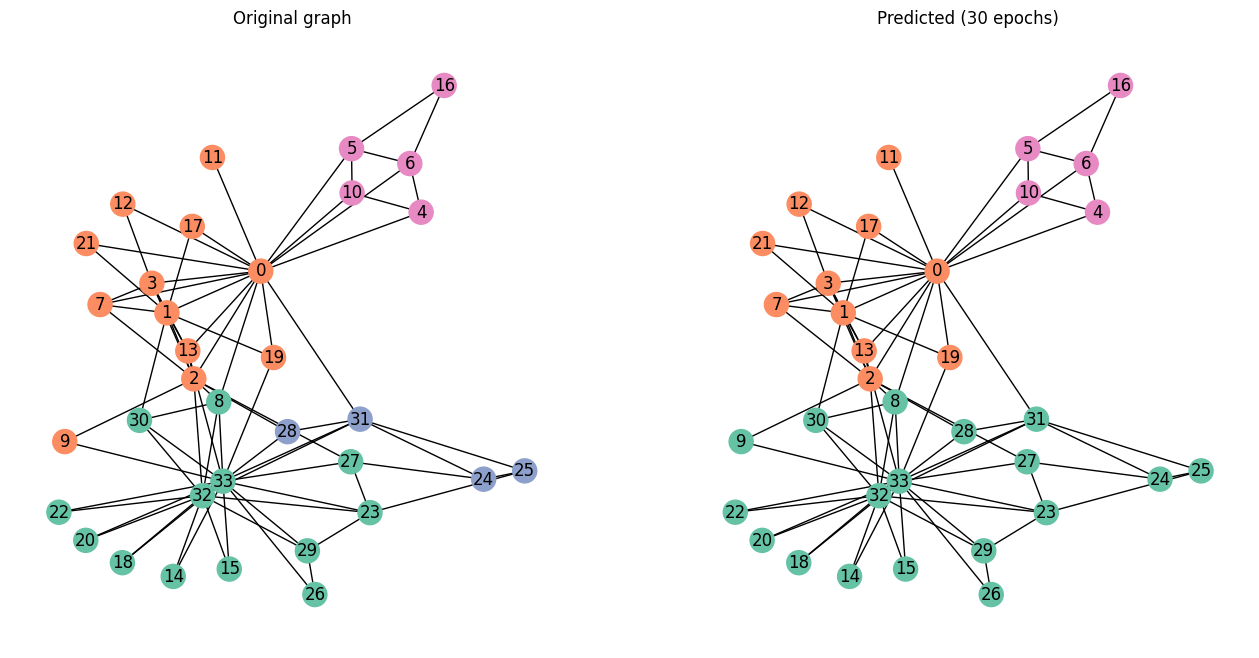

In [23]:
# plot nodes of the training set, unused nodes color is gray
plt.figure(figsize=(16, 8))

# Create an adjacency matrix
adjacency_matrix = generate_adjacency_matrix(data.num_nodes, data.edge_index)
# Now create the graph
nx_G = nx.Graph(adjacency_matrix)
# Create the layout
pos = nx.spring_layout(nx_G, seed=42)

color_map = plt.get_cmap("Set2")

out = model(data.x, data.edge_index)

original_colors = [color_map.colors[data.y[i].item()] for i in range(data.num_nodes)]
predicted_colors = [color_map.colors[i] for i in out.argmax(dim=1)]

# Plot the original graph

plt.subplot(1, 2, 1)
nx.draw(nx_G, pos, with_labels=True, node_color=original_colors, cmap="Set2")
plt.title("Original graph")

# Plot the training set
plt.subplot(1, 2, 2)
nx.draw(nx_G, pos, with_labels=True, node_color=predicted_colors, cmap="Set2")
plt.title("Predicted (30 epochs)")

plt.show()

In [24]:
model = GCN(in_channels=-1, hidden_channels=64, out_channels=dataset.num_classes)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
model.train()
for epoch in range(100):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)

    loss = criterion(out[data.train_mask], data.y_encoded[data.train_mask])
    loss.backward()
    optimizer.step()

    acc = (out[data.train_mask].argmax(dim=1) == data.y[data.train_mask]).sum().item() / data.train_mask.sum().item()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss {loss.item()} | Train Accuracy {acc}")

Epoch 0 | Loss 1.3851042985916138 | Train Accuracy 0.1111111111111111
Epoch 10 | Loss 0.8896350264549255 | Train Accuracy 0.7407407407407407
Epoch 20 | Loss 0.42304784059524536 | Train Accuracy 0.8888888888888888
Epoch 30 | Loss 0.18537789583206177 | Train Accuracy 1.0
Epoch 40 | Loss 0.09570396691560745 | Train Accuracy 1.0
Epoch 50 | Loss 0.05377676337957382 | Train Accuracy 1.0
Epoch 60 | Loss 0.03102184645831585 | Train Accuracy 1.0
Epoch 70 | Loss 0.019196920096874237 | Train Accuracy 1.0
Epoch 80 | Loss 0.012976914644241333 | Train Accuracy 1.0
Epoch 90 | Loss 0.00947399903088808 | Train Accuracy 1.0


In [25]:
# Test the model

model.eval()
out = model(data.x, data.edge_index)

acc = (out[data.test_mask].argmax(dim=1) == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
print(f"Test Accuracy {acc}")

Test Accuracy 1.0


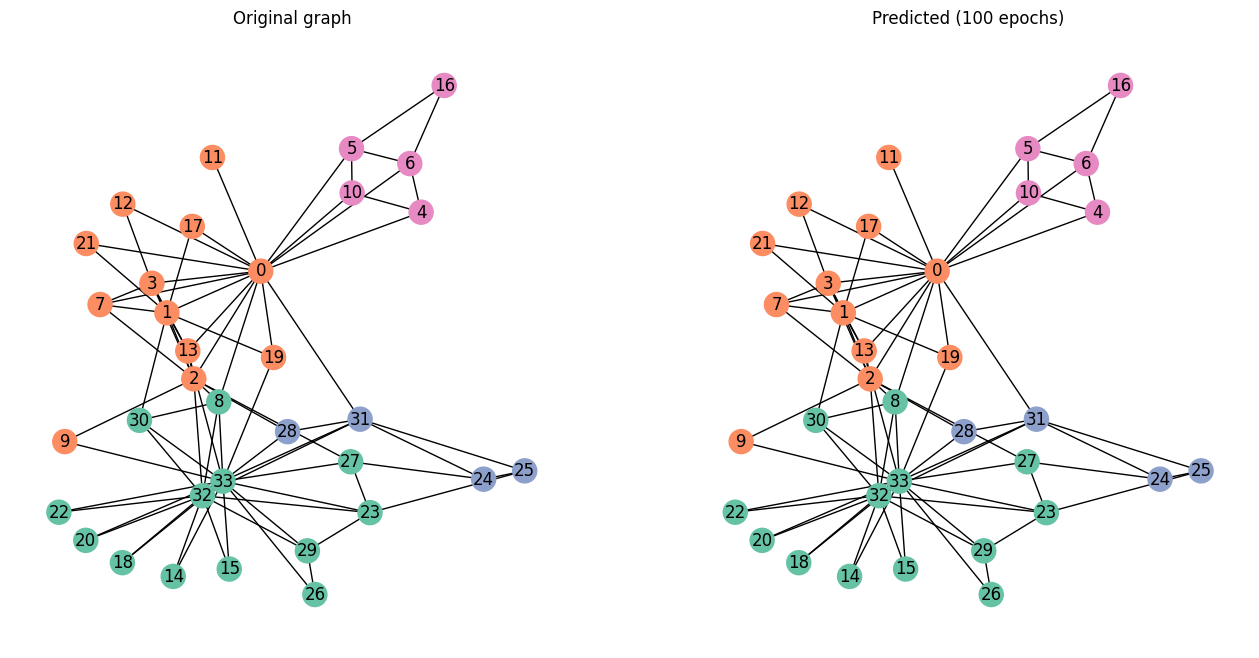

In [26]:
# plot nodes of the training set, unused nodes color is gray
plt.figure(figsize=(16, 8))

# Create an adjacency matrix
adjacency_matrix = generate_adjacency_matrix(data.num_nodes, data.edge_index)
# Now create the graph
nx_G = nx.Graph(adjacency_matrix)
# Create the layout
pos = nx.spring_layout(nx_G, seed=42)

color_map = plt.get_cmap("Set2")

out = model(data.x, data.edge_index)

original_colors = [color_map.colors[data.y[i].item()] for i in range(data.num_nodes)]
predicted_colors = [color_map.colors[i] for i in out.argmax(dim=1)]

# Plot the original graph

plt.subplot(1, 2, 1)
nx.draw(nx_G, pos, with_labels=True, node_color=original_colors, cmap="Set2")
plt.title("Original graph")

# Plot the training set
plt.subplot(1, 2, 2)
nx.draw(nx_G, pos, with_labels=True, node_color=predicted_colors, cmap="Set2")
plt.title("Predicted (100 epochs)")

plt.show()

In [27]:
# now let's try to add additional node connected to node 16

# zeros of size 34 x 1

new_node = torch.zeros((1, data.x.shape[1]))
edges = torch.tensor([[16, 34], [34, 16]], dtype=torch.long)

data.xx = torch.cat([data.x, new_node], dim=0)
data.edge_indexx = torch.cat([data.edge_index, edges], dim=1)
data.yy = torch.cat([data.y, torch.tensor([3])], dim=0)

In [28]:
data.yy

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 3])

In [29]:
data.num_nodes

34

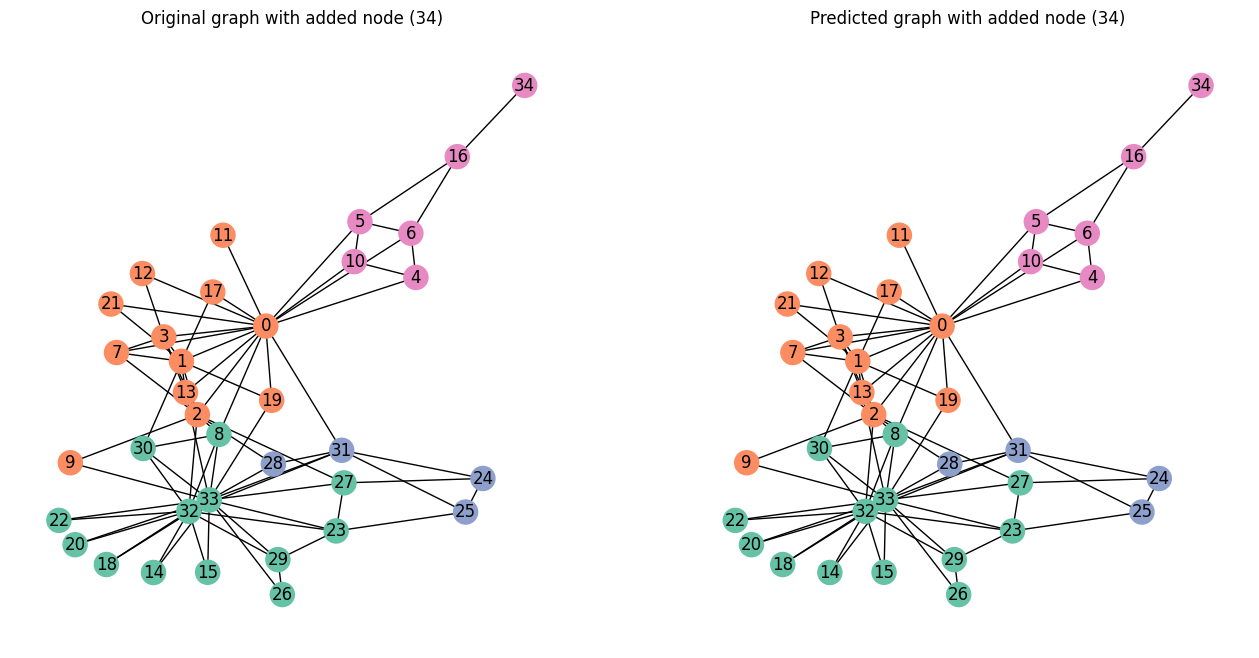

In [30]:
# plot nodes of the training set, unused nodes color is gray
plt.figure(figsize=(16, 8))

# Create an adjacency matrix
adjacency_matrix = generate_adjacency_matrix(data.num_nodes + 1, data.edge_indexx)
# Now create the graph
nx_G = nx.Graph(adjacency_matrix)
# Create the layout
pos = nx.spring_layout(nx_G, seed=42)

color_map = plt.get_cmap("Set2")

out = model(data.xx, data.edge_indexx)

original_colors = [color_map.colors[data.yy[i].item()] for i in range(data.num_nodes + 1)]
predicted_colors = [color_map.colors[i] for i in out.argmax(dim=1)]

# Plot the original graph
plt.subplot(1, 2, 1)
nx.draw(nx_G, pos, with_labels=True, node_color=original_colors, cmap="Set2")
plt.title("Original graph with added node (34)")

# Plot the training set
plt.subplot(1, 2, 2)
nx.draw(nx_G, pos, with_labels=True, node_color=predicted_colors, cmap="Set2")
plt.title("Predicted graph with added node (34)")

plt.show()

No i teraz sie zgadza !!!

### Texas